In [1]:
from pathlib import Path
from collections import namedtuple

import numpy as np
import pandas as pd
import xarray as xr

import esmlab
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc # colortables
import palettable     # more colortables!


In [2]:
model_colors = {}
for i, m in [(0, "cesm"), (1, "cnrm"), (2, "ipsl"), (3, "mri"), (6, "hadgem")]:
    model_colors[m] = cc.cm.glasbey_hv(i) 

# hard code locking to other blues, assumes CESM is first in list.
model_colors['f-lock'] = cc.cm.glasbey_hv(5)
model_colors['f-cntl'] = model_colors['f-lock']
model_colors['c-lock'] = cc.cm.glasbey_hv(8)
model_colors['c-cntl'] = model_colors['c-lock']

In [3]:
def get_duration_and_size(lab, rettype='df'):
    """Returns either a Pandas DataFrame (default) or dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    # put eventID as key, values are dict: {duration: D, size: [s_0, ..., s_d]}
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev]['duration'] += 1 # continuing
                    dur[ev]['size'].append(np.count_nonzero(tmp==ev))
                else:
                    dur[ev] = dict() # new event
                    dur[ev]['duration'] = 1
                    dur[ev]['size'] = [np.count_nonzero(tmp==ev)]
    if rettype == 'df':
        # convert to dataFrame
        df = pd.DataFrame.from_dict(dur, orient ='index')
        # compute average size and include as a column
        asiz = []
        msiz = []
        for s in df['size']:
            asiz.append(np.mean(s))
            msiz.append(np.max(s))
        df['AvgSiz'] = asiz
        df['MaxSiz'] = msiz
        # get distribution of average size
        return df
    else:
        return dur  # AvgSiz and MaxSiz not included in output dict.


def summarize_events(labels, mstr, estr):
    X = get_events_per_time(labels)
    Y = get_duration_and_size(labels)  # Y is a pandas DF with columns: duration, size, AvgSiz, MaxSiz
    tot_number_events = len(Y)
#     dur = []
#     avgsiz = []
#     mxsiz = []
#     for ev in Y:
#         dur.append(Y[ev]["duration"])
#         avgsiz.append(np.mean(Y[ev]["size"]))
#         mxsiz.append(np.max(Y[ev]["size"]))
    avg_duration = np.mean(Y['duration'])
    std_duration = np.std(Y['duration'])
    avg_size = np.mean(Y['AvgSiz'])
    std_size = np.std(Y['AvgSiz'])
    avg_mx_size = np.mean(Y['MaxSiz'])
    std_mx_size = np.std(Y['MaxSiz'])
    print(
        f"{mstr} {estr}: [N_events] = {np.mean(X):.2f} ± {np.std(X):.2f}, Ntot: {tot_number_events:.2f}, [D] = {avg_duration:.2f} ± {std_duration:.2f}, [S] = {avg_size:.2f} ± {std_size:.2f}, [Smx] = {avg_mx_size:.2f} ± {std_mx_size:.2f}"
    )

In [13]:
#
# In order to normalize "size", we need to get the number of tropical ocean points
#
def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError(f"Can not find the files: {str(loc)}, {var}, {table}, {model}, {experiment}, {member}")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

def get_cmip_npoints(loc, model, experiment, member, derive=None):
    tropics = slice(-30,30)
    if derive is None:
        land = quick_load_var(data_loc, "sftlf", "fx", model, experiment, member)
    else :
        land = quick_load_var(data_loc, derive, "Amon", model, experiment, member)
        land = (land.isel(time=0).squeeze()) * 0  # This just takes a single time and makes an array of zeros for aquaplanet
    land_trop = land.sel(lat=tropics)
    ocean = np.where(land_trop <= 0, 1, 0)
    return np.sum(ocean.flatten())
        
def get_cesm_npoints():
    land_f = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
    landx = land_f['LANDFRAC'].squeeze()
    tropics = slice(-30,30)
    land_trop = landx.sel(lat=tropics)
    ocean = np.where(land_trop <= 0, 1, 0)
    return np.sum(ocean.flatten())

In [14]:
DRIVE = "Jedha"

data_loc = Path(f"/Volumes/{DRIVE}/CMIP6")
## do these:

sims = {"cesm-amip": ("CESM2", "amip", "r1i1p1f1"),
        "cesm-amip-off": ("CESM2","amip-lwoff","r1i1p1f1"),
        "cesm-aqua": ("CESM2", "aqua-control", "r1i1p1f1"),
        "cesm-aqua-off": ("CESM2", "aqua-control-lwoff", "r1i1p1f1"),
        "ipsl-amip": ("IPSL-CM6A-LR", "amip", "r1i1p1f1"),
        "ipsl-amip-off": ("IPSL-CM6A-LR", "amip-lwoff", "r1i1p1f1"),
        "ipsl-aqua": ("IPSL-CM6A-LR", "aqua-control", "r1i1p1f1"),
        "ipsl-aqua-off": ("IPSL-CM6A-LR", "aqua-control-lwoff", "r1i1p1f1"),
        "cnrm-amip": ("CNRM-CM6-1", "amip", "r1i1p1f2"),
        "cnrm-amip-off": ("CNRM-CM6-1", "amip-lwoff", "r1i1p1f2"),
        "cnrm-aqua": ("CNRM-CM6-1", "aqua-control", "r1i1p1f2"),
        "cnrm-aqua-off": ("CNRM-CM6-1", "aqua-control-lwoff", "r1i1p1f2"),
        "mri-amip" : ("MRI-ESM2-0", "amip", "r1i1p1f1"),
        "mri-amip-off" : ("MRI-ESM2-0", "amip-lwoff", "r1i1p1f1"),
        "hadgem-amip" :("HadGEM3-GC31-LL", "amip", "r1i1p1f3"),
        "hadgem-amip-off": ("HadGEM3-GC31-LL", "amip-lwoff", "r5i1p1f2"),
        "hadgem-aqua" :("HadGEM3-GC31-LL", "aqua-control", "r1i1p1f3"),
        "hadgem-aqua-off": ("HadGEM3-GC31-LL", "aqua-control-lwoff", "r1i1p1f3"),
       }

# Add the locking results:
locking_loc = Path(f"/Volumes/{DRIVE}/cloud_locking/pr_events")
variable = "PRECT"
cases = {
    'f-lock': locking_loc / 'pr_events_F1850JJB_c201_CLOCK.nc',
    'f-cntl': locking_loc / 'pr_events_F1850JJB_c201_CTL.nc',
    'c-lock': locking_loc / 'pr_events_B1850_c201_CLOCK.nc',
    'c-cntl': locking_loc / 'pr_events_B1850_c201_CTL.nc'}

case_names = {'f-lock': 'F1850JJB_c201_CLOCK',
    'f-cntl': 'F1850JJB_c201_CTL',
    'c-lock': 'B1850_c201_CLOCK',
    'c-cntl': 'B1850_c201_CTL'}


# ensure correct order:
order = ['f-cntl', 'f-lock', 'c-cntl', 'c-lock',
        'cesm-amip',
        'cesm-amip-off',
        'cesm-aqua',
        'cesm-aqua-off',
        'cnrm-amip',
        'cnrm-amip-off',
        'cnrm-aqua',
        'cnrm-aqua-off',
        'hadgem-amip',
        'hadgem-amip-off',
        'hadgem-aqua',
        'hadgem-aqua-off',
        'ipsl-amip',
        'ipsl-amip-off',
        'ipsl-aqua',
        'ipsl-aqua-off',
        'mri-amip',
        'mri-amip-off',
]

R = {}
OceanPoints = {}
for c in order:
    print(f"working on {c}")
    if c in sims:
        R[c] = xr.open_dataset(data_loc / f"pr_events_{'_'.join(sims[c])}.nc")
        if 'hadgem' in c:
            derive = "pr"
        else:
            derive = None
        OceanPoints[c] = get_cmip_npoints(data_loc, *sims[c], derive=derive)
    else:
        R[c] = xr.open_dataset(cases[c])
        OceanPoints[c] = get_cesm_npoints()
        


working on f-cntl
working on f-lock
working on c-cntl
working on c-lock
working on cesm-amip
working on cesm-amip-off
working on cesm-aqua


/Users/brianpm/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


working on cesm-aqua-off
working on cnrm-amip
working on cnrm-amip-off
working on cnrm-aqua
working on cnrm-aqua-off
working on hadgem-amip
working on hadgem-amip-off
working on hadgem-aqua
working on hadgem-aqua-off
working on ipsl-amip
working on ipsl-amip-off
working on ipsl-aqua
working on ipsl-aqua-off
working on mri-amip
working on mri-amip-off


In [15]:
D = {}
for c in R:
    print(c)
    evnt = R[c]['precip_events']
    D[c] = get_duration_and_size(evnt, rettype='df')

f-cntl
f-lock
c-cntl
c-lock
cesm-amip
cesm-amip-off
cesm-aqua
cesm-aqua-off
cnrm-amip
cnrm-amip-off
cnrm-aqua
cnrm-aqua-off
hadgem-amip
hadgem-amip-off
hadgem-aqua
hadgem-aqua-off
ipsl-amip
ipsl-amip-off
ipsl-aqua
ipsl-aqua-off
mri-amip
mri-amip-off


In [16]:
# get the number of events at each time, then get the median & iqr
def get_n_events(events):
    unvals = np.zeros(events.shape[0])
    for t in range(events.shape[0]):
        unvals[t] = np.unique(events[t,:,:]).shape[0]
        if unvals[t] > 0:
            unvals[t] -= 1
    return np.quantile(unvals, [0.25, 0.5, 0.75])


N = {}
for c in R:
    evnt = R[c]['precip_events'].values
    N[c] = get_n_events(evnt)
    

In [17]:
#
# We need to know the number, duration, and size when we exclude events that only last 1-day or have max size of 1 point
#
Dlg = {}
for c in D:
    dursiz1 = D[c]
    evlong1 = dursiz1.where(dursiz1['duration'] > 2).dropna()
    evlarg = evlong1.where(evlong1['MaxSiz'] > 2).dropna()
    Dlg[c] = evlarg


f-cntl f-cntl
f-lock f-lock
c-cntl c-cntl
c-lock c-lock
cesm-amip cesm
cesm-amip-off cesm
cesm-aqua cesm
cesm-aqua-off cesm
cnrm-amip cnrm
cnrm-amip-off cnrm
cnrm-aqua cnrm
cnrm-aqua-off cnrm
hadgem-amip hadgem
hadgem-amip-off hadgem
hadgem-aqua hadgem
hadgem-aqua-off hadgem
ipsl-amip ipsl
ipsl-amip-off ipsl
ipsl-aqua ipsl
ipsl-aqua-off ipsl
mri-amip mri
mri-amip-off mri


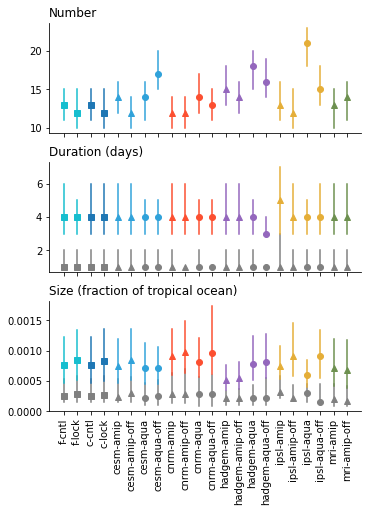

In [22]:

fig, ax = plt.subplots(figsize=(5,7), nrows=3, sharex=True, constrained_layout=True)
xval = 1
for c in N:
    pieces = c.split("-")
    if c not in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']:
        model = pieces[0]
    else:
        model = c
    if ('amip' in c):
        m = '^'
    elif (c in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']):
        m = "s"
    else:
        m = 'o'
    print(c, model)
    mfill = 'full'
    mafill = 'none'

    # NUMBER
    ax[0].plot(xval, N[c][1], marker=m, color=model_colors[model], fillstyle=mfill) # MEDIAN
    ax[0].plot([xval,xval], [N[c][0], N[c][2]], color=model_colors[model]) # IQR
    
    # DURATION
    qtmp = np.quantile(D[c]['duration'].values, [0.25, 0.5, 0.75])
    ax[1].plot(xval, qtmp[1], marker=m, color='gray', fillstyle=mfill)
    ax[1].plot([xval, xval], [qtmp[0], qtmp[2]], color='gray')
    qtmp = np.quantile(Dlg[c]['duration'].values, [0.25, 0.5, 0.75])
    ax[1].plot(xval, qtmp[1], marker=m, color=model_colors[model], fillstyle=mfill)
    ax[1].plot([xval, xval], [qtmp[0], qtmp[2]], color=model_colors[model])
    

    #ax[1].plot(xval, RR[c].toavg_uw*86400.0, marker='*', color=model_colors[model], fillstyle=mfill)
    
    # SIZE
    qtmp = np.quantile(D[c]['AvgSiz'].values, [0.25, 0.5, 0.75])
    ax[2].plot(xval, qtmp[1]/OceanPoints[c], marker=m, fillstyle=mfill, color='gray')
    ax[2].plot([xval, xval], [qtmp[0]/OceanPoints[c], qtmp[-1]/OceanPoints[c]], color='gray')
#     ax[2].plot(xval, D[c]['AvgSiz'].median()/OceanPoints[c], marker=m, fillstyle=mfill, color='gray')

    qtmp = np.quantile(Dlg[c]['AvgSiz'].values, [0.25, 0.5, 0.75])
    ax[2].plot(xval, qtmp[1]/OceanPoints[c], marker=m, fillstyle=mfill, color=model_colors[model])
    ax[2].plot([xval, xval], [qtmp[0]/OceanPoints[c], qtmp[-1]/OceanPoints[c]], color=model_colors[model])
#     ax[3].plot(xval, R[c].xsum/R[c].tsum, marker=m, fillstyle=mfill, color=model_colors[model])
    xval += 1

ax[0].set_title("Number", loc='left')
ax[1].set_title("Duration (days)", loc='left')
ax[2].set_title("Size (fraction of tropical ocean)", loc='left')

ax[-1].set_xticks(np.arange(1, len(R)+1))
ax[-1].set_xticklabels(R.keys(), rotation=90)

[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]

# #
# from matplotlib.lines import Line2D
# legend_elements_last = [Line2D([0], [0], marker="^", linestyle="None", fillstyle='full', color="darkgray", label='AMIP Ocean'),
#                         Line2D([0], [0], marker="^", linestyle="None", fillstyle='none', color="darkgray", label='AMIP All'),            
#                         Line2D([0], [0], marker="o", linestyle="None", fillstyle='full', color="darkgray", label='Aqua'),
#                         Line2D([0], [0], marker="s", linestyle="None", fillstyle='full', color="darkgray", label='Locking Ocean'),
#                         Line2D([0], [0], marker="s", linestyle="None", fillstyle='none', color="darkgray", label='Locking All'),
#                   ]

# fig.legend(handles=legend_elements_last, loc='lower center', bbox_to_anchor=(.5, -0.09), frameon=True, ncol=2)


fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/summary_event_stats_v2.pdf", bbox_inches='tight')

f-cntl f-cntl
f-lock f-lock
c-cntl c-cntl
c-lock c-lock
cesm-amip cesm
cesm-amip-off cesm
cesm-aqua cesm
cesm-aqua-off cesm
cnrm-amip cnrm
cnrm-amip-off cnrm
cnrm-aqua cnrm
cnrm-aqua-off cnrm
hadgem-amip hadgem
hadgem-amip-off hadgem
hadgem-aqua hadgem
hadgem-aqua-off hadgem
ipsl-amip ipsl
ipsl-amip-off ipsl
ipsl-aqua ipsl
ipsl-aqua-off ipsl
mri-amip mri
mri-amip-off mri


[None, None, None]

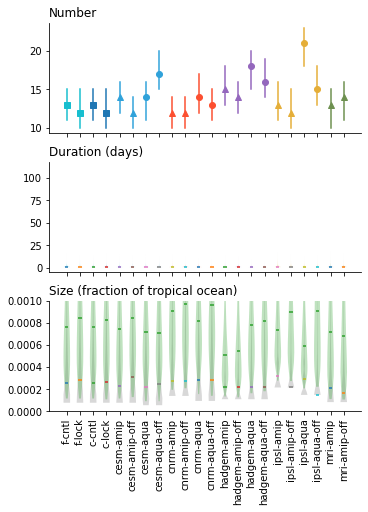

In [19]:

fig, ax = plt.subplots(figsize=(5,7), nrows=3, sharex=True, constrained_layout=True)

violins1 = []
violins2 = []
violins2g = []

vdata = [Dlg[c]['AvgSiz']/OceanPoints[c] for c in Dlg]

xval = 1
for c in N:
    pieces = c.split("-")
    if c not in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']:
        model = pieces[0]
    else:
        model = c
    if ('amip' in c):
        m = '^'
    elif (c in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']):
        m = "s"
    else:
        m = 'o'
    print(c, model)
    mfill = 'full'
    mafill = 'none'

    # NUMBER
    ax[0].plot(xval, N[c][1], marker=m, color=model_colors[model], fillstyle=mfill) # MEDIAN
    ax[0].plot([xval,xval], [N[c][0], N[c][2]], color=model_colors[model]) # IQR
    
    # DURATION
    qtmp = D[c]['duration']
    violins1.append(ax[1].violinplot(qtmp, [xval], vert=True, showmedians=True, showextrema=False))
    [pc.set_facecolor(model_colors[model]) for pc in violins1[-1]['bodies']]
    

    #ax[1].plot(xval, RR[c].toavg_uw*86400.0, marker='*', color=model_colors[model], fillstyle=mfill)
    
    # SIZE
    violins2g.append(ax[2].violinplot(D[c]['AvgSiz']/OceanPoints[c], [xval], vert=True, showextrema=False,
                                    showmedians=True))
    [pc.set_facecolor("gray") for pc in violins2g[-1]['bodies']]
#     violins2g[-1]['cmedians'].set_color("gray")


#     violins2.append(ax[2].violinplot(Dlg[c]['AvgSiz']/OceanPoints[c], [xval], vert=True, showextrema=False,
#                                     showmedians=True))
#     [pc.set_facecolor(model_colors[model]) for pc in violins2[-1]['bodies']]
#     violins2[-1]['cmedians'].set_color(model_colors[model])



#     ax[2].plot(xval, D[c]['AvgSiz'].median()/OceanPoints[c], marker=m, fillstyle=mfill, color='gray')
#     ax[2].plot(xval, Dlg[c]['AvgSiz'].median()/OceanPoints[c], marker=m, fillstyle=mfill, color=model_colors[model])
#     ax[3].plot(xval, R[c].xsum/R[c].tsum, marker=m, fillstyle=mfill, color=model_colors[model])

    xval += 1

ax[2].violinplot(vdata, vert=True, showextrema=False, showmedians=True)    

ax[0].set_title("Number", loc='left')
ax[1].set_title("Duration (days)", loc='left')
ax[2].set_title("Size (fraction of tropical ocean)", loc='left')
ax[2].set_ylim([0, 0.001])

ax[-1].set_xticks(np.arange(1, len(R)+1))
ax[-1].set_xticklabels(R.keys(), rotation=90)

[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]

# #
# from matplotlib.lines import Line2D
# legend_elements_last = [Line2D([0], [0], marker="^", linestyle="None", fillstyle='full', color="darkgray", label='AMIP Ocean'),
#                         Line2D([0], [0], marker="^", linestyle="None", fillstyle='none', color="darkgray", label='AMIP All'),            
#                         Line2D([0], [0], marker="o", linestyle="None", fillstyle='full', color="darkgray", label='Aqua'),
#                         Line2D([0], [0], marker="s", linestyle="None", fillstyle='full', color="darkgray", label='Locking Ocean'),
#                         Line2D([0], [0], marker="s", linestyle="None", fillstyle='none', color="darkgray", label='Locking All'),
#                   ]

# fig.legend(handles=legend_elements_last, loc='lower center', bbox_to_anchor=(.5, -0.09), frameon=True, ncol=2)


# fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/summary_event_stats.pdf", bbox_inches='tight')